# **7장 - 앙상블 학습과 랜덤 포레스트**

_이 노트북에는 7장의 모든 샘플 코드와 연습 문제에 대한 솔루션이 포함되어 있습니다._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/handson-ml3/blob/main/07_ensemble_learning_and_random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# 설정

이 프로젝트에는 파이썬 3.7 이상이 필요합니다:

In [1]:
import sys

assert sys.version_info >= (3, 7)

또한 사이킷런 ≥ 1.0.1이 필요합니다:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

이전 챕터에서와 마찬가지로 기본 글꼴 크기를 정의하여 그림을 더 예쁘게 만들어 보겠습니다:

In [3]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import koreanize_matplotlib  

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
# if 'google.colab' in sys.modules:
#     !sudo apt-get -qq -y install fonts-nanum
#     import matplotlib.font_manager as fm
#     font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
#     for fpath in font_files:
#         fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
# import matplotlib

# matplotlib.rc('font', family='NanumBarunGothic')
# matplotlib.rcParams['axes.unicode_minus'] = False

# 나눔 폰트 경로 설정
# font_path = "C:/Windows/Fonts/NanumBarunGothic.ttf"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)
# plt.rc('font', family=font)

# plt.rcParams['axes.unicode_minus'] = False


그리고 아직 존재하지 않는 경우 `images/ensembles` 폴더를 만들고, 이 노트북을 통해 책에 사용할 그림을 고해상도로 저장하는 데 사용되는 `save_fig()` 함수를 정의해 보겠습니다:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

랜덤으로 선택된 수천 명의 사람에게 복잡한 질문을 하고 대답을 모은다고 가정합시다. 많은 경우 이렇게 모은 답이 전문가의 답보다 낫습니다. 이를 **대중의 지혜 wisdom of the crowd** 라고 합니다. 

이와 비슷하게 일련의 예측기(즉, 분류나 회귀 모델)로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있을 것입니다. 일련의 예측기를 **앙상블**이라고 부르기 때문에 이를 **앙상블 학습 ensemble learning**이라고 하며 앙상블 학습 알고리즘을 **(앙상블 방법 ensemble method)** 이라고 합니다.

앙상블 방법의 예를 들면 훈련 세트로부터 랜덤으로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련시킬 수 있습니다. 개별 트리의 예측을 모아 가장 많은 선택을 받은 클래스를 앙상블의 예측으로 삼습니다（6장의 마지막 연습문제를 참고하세요）. 

**결정 트리의 앙상블을 랜덤 포레스트**라고 합니다. 간단한 방법임에도 랜덤 포레스트는 오늘날 가장 강력한 머신러닝 알고리즘입니다.

(2장에서 언급한 것처럼) 프로젝트의 마지막에 다다르면 흔히 앙상블 방법을 사용하여 여러 괜찮은 예측기를 연결하여 더 좋은 예측기를 만듭니다. 사실 머신러닝 경연 대회에서 우승히는 솔루션은 여러 가지 앙상블 방법을 사용한 경우가 많습니다. 이는 특히 넷플릭스 대회 (http://netflixprize.com/) 에서 가장 유명힙니다.

이 장에서는 

- 투표 기반 분류기, 
- 배깅과 페이스팅 앙상블, 
- 랜덤 포레스트, 
- 부스팅, 
- 스태킹 앙상블 등 

가장 인기 있는 앙상블 방법을 설명하겠습니다.

# 7.1 투표 기반 분류기

정확도가 80%인 분류기 여러 개를 훈련시켰다고 가정합시다.  
아마도 **로지스틱 회귀 분류기, SVM 분류기, 랜덤 포레스트 분류기, k-최근접 이웃 분류기** 등을 가지고 있을 수 있습니다.

<img src="./images/fig07-01.png" width="50%"></img>

더 좋은 분류기를 만드는 매우 간단한 방법은 각 분류기의 예측을 집계하는 것입니다. 가장 많은 표를 얻은 클래스가 앙상블의 예측이 됩니다.  
이렇게 **다수결 투표**로 정해지는 분류기를 **직접 투표 hard voting** 분류기 라고 합니다.

<img src="./images/fig07-02.png" width="50%"></img>

조금 놀랍게도 이 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다도 정확도가높은 경우가 많습니다.

사실 각분류기가 **약한 학습기 weak Learner** (랜덤 추측보다 조금 더 높은 성능을 내는 분류기) 일지라도 앙상블에 있는 **약한 학습기가 충분하게 많고 다양**하다면 앙상블은 (높은 정확도를 내는) **강한 학습기 strong learner**가 될 수 있습니다.

이게 어떻게 가능할까요? 다음 설명이 이 미스터리를 조금 밝혀줄 것입니다. 동전을 던졌을 때 앞면이 51%, 뒷면이 49%가 나오는 조금 균형이 맞지 않는 동전이 있다고 가정하겠습니다. 이 
동전을 1,000번 던진다면 대략 510번은 앞면, 490번은 뒷면이 나올 것이므로 다수는 앞면이 됩니다. 수학적으로 계산해보면 1,000번을 던진 후 앞면이 다수가 될 확률은 75%에 가깝다 
는 것을 확인할 수 있습니다. 더 많이 던질수록 확률은 증가합니다(예를 들어 10,000번 던지면 획률이 97% 이상으로 올라갑니다)

이는 **큰 수의 법칙 law of large numbers** 때문입니다. 동전을 자꾸 던질수록 앞면이 나오는 비율은 점점 더 앞면이 나올 확률(51%) 에 가까워집니다. 

[그림 7-3]은 균형이 틀어진 동전을 10번 실험한 그래프입니다.  
던진 횟수가 증가할수록 앞면이 나올 획률 51%에 가까워집니다. 결국 10번의 실험 모두 50%보다 높게 유지되며 51%에 수렴하면서 끝나고 있습니다

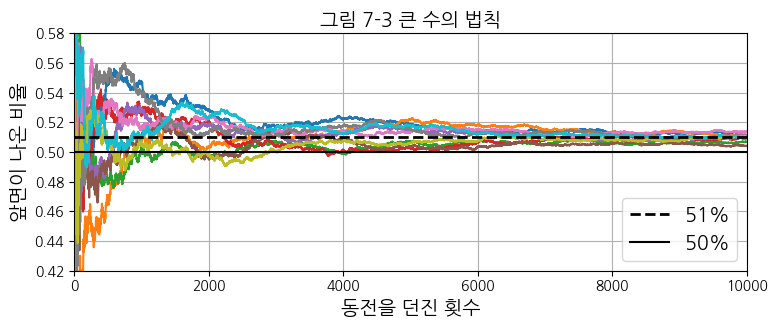

In [33]:
# 추가 코드 - 이 셀은 그림 7-3을 생성하고 저장합니다.

import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("동전을 던진 횟수")
plt.ylabel("앞면이 나온 비율")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.title('그림 7-3 큰 수의 법칙')
plt.grid()
save_fig("law_of_large_numbers_plot")
plt.show()

투표 기반 분류기를 만들어 보겠습니다:

**이와 비슷하게 (랜덤 추측보다 조금 더 나은) 51% 정확도를 가진 1,000개의 분류기로 앙상블 모델을 구축한다고 가정합시다.** 

가장 많은 클래스를 예측으로 삼는다면 75%의 정확도를 기대할 수 있습니다! 

하지만 **이런 가정은 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없어야 가능합니다.** 하지만 여기서는 같은 데이터로 훈련시키기 때문에 이런 가정이 맞지 않습니다. 분류기들이 같은 종류의 오차를 만들기 쉽기 때문에 잘못된 클래스가 다수인 경우가 많고 앙상블의 정확도가 낮아집니다.

> TIP **앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘합니다.** 다양한 분류기를 얻는 한 가지 방법은 각기 다른 알고리즘으로 학습시키는 것입니다. 이렇게 하면 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도가 향상됩니다.

**사이킷런**은 이름/예측기 쌍의 리스트를 제공하기만 하면 일반 분류기처럼 쉽게 사용할 수 있는 **VotingClassifier 클래스**를 제공합니다. 5장에서 소개한 moons 데이터셋에서 사용해보겠습니다. moons 데이터셋을 로드하고 훈련 세트와 테스트 세트로 분할한 다음 세 가지 다양한 분류기로 구성된 투표 기반 분류기를 생성하고 훈련하겠습니다

In [34]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

**Votingclassifier를 훈련**할 때 이 클래스는 모든 추정기를 복제하여 **복제된 추정기를 훈련**합니다.  
**원본 추정기는 estimators 속성**을 통해 참조할 수 있으며 **훈련된 복제본은 estimators_ 속성**에 저장됩니다.  

리스트 대신 딕셔너리를 전달하는 경우 named_estimators 또는 named_estimators_를 사용할 수 있습니다.

먼저 테스트 세트에서 훈련된 각 분류기의 정확도를 살펴보겠습니다.

In [35]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


투표 기반 분류기의 **predict() 메서드를 호출하면 직접 투표를 수행**합니다. 

예를 들어 이 투표 기반 분류기는 테스트 세트의 첫 번째 샘플에 대해 클래스 1을 예측하는데, 이는 세 분류기 중 두 분류기가 해당 클래스를 예측하기 때문입니다.

In [36]:
voting_clf.predict(X_test[:1])

array([1], dtype=int64)

In [37]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64)]

이제 테스트 세트에서 투표 기반 분류기의 성능을 살펴보겠습니다.

In [38]:
voting_clf.score(X_test, y_test)

0.912

예상대로입니다! 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높습니다. 

이제 간접 투표를 사용해 보겠습니다:

**모든 분류기가 클래스의 확률을 예측할 수 있으면**(즉, predict_proba() 메서드가 있으면) **개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측**할 수 있습니다. 

이를 **간접 투표 soft voting** 라고 힙니다. 

**이 방식은 획률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식 보다 성능이 높습니다.**  
이 방식을 사용하기 위해서는 투표 기반 분류기의 voting 매개변수를 "soft"로 바꾸고 모든 분류기가 클래스의 확률을 추정할 수 있도록 하면 됩니다.  

SVC는 기본값에서는 클래스 확률을 제공하지 않으므로 probability 매개변수를 True로 지정해야 합니다(이렇게 하면 클래스 확률을 추정하기 위해 교차 검증을 사용하므로 훈련 속도가 느려지지만 SVC에서 predict_proba() 메서드를 사용할 수 있습니다 ). 

한번 시도해보죠.

In [39]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

간접 투표 방식을 사용해 92% 정확도를 달성했습니다. 나쁘지 않군요!

# 7.2 배깅과 페이스팅

앞서 말했듯이 다양한 분류기를 만드는 한 가지 방법은 각기 다른 훈련 알고리즘을 사용하는 것입니다. 

**또 다른 방법은 같은 알고리즘을 사용**하고 **훈련 세트의 서브셋을 랜덤으로 구성하여 분류기를 각기 다르게 학습시키는 것**입니다. 

훈련 세트에서 중복을 허용하여 샘플링하는 방식을 **배깅 bagging**(bootstrap aggregating의 줄임말)이라 하며,

중복을 허용하지 않고 샘플링하는 방식을 **페이스팅 pasting**이라고 합니다.

다시 말해 배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용할 수 있습니다.  
하지만 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링할 수 있습니다. 

이 샘플링과 훈련 과정을 [그림 7-4]에 나타냈습니다

<img src="./images/fig07-04.png" width="50%"></img>

모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듭니다.  

집계 함수는 일반적으로 분류일 때는 통계적 최빈값 statistical mode (직접 투표 분류기처럼 가장 많은 예측 결과) 을, 회귀에 대해서는 평균을 계산합니다. 

**개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향**되어 있지만 **집계 함수를 통과하면 편향과 분산이 모두 감소**합니다.  
일반적으로 **앙상블의 결과**는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 **편향은 비슷하지만 분산은 줄어듭니다**.

[그림 7-4]에서 볼 수 있듯이 예측기는 동시에 다른 CPU 코어나 서버에서 **병렬로 학습**시킬 수 있습니다.  
이와 유사하게 예측도 병렬로 수행할 수 있습니다. 이런 확장성 덕분에 배깅과 페이스팅의 인기가 높습니다.

## 7.2.1 사이킷런의 배깅과 페이스팅

**사이킷런**은 배깅과 페이스팅을 위해 간편한 API로 구성된 **Baggingclassifier(회귀의 경우에는 BaggingRegressor)를 제공**합니다. 

다음은 결정 트리 분류기 500개의 앙상블을 훈련시키는 코드입니다.  
각 분류기는 훈련 세트에서 중복을 허용하여 랜덤으로 선택된 100개의 샘플로 훈련됩니다  
(이는 배깅의 경우이고, 페이스팅을 사용하려면 bootstrap=False로 지정하면 됩니다).  
n_jobs 매개변수는 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정합니다. -1로 지정하면 가용한 모든 코어를 사용합니다.

In [42]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

> **NOTE** BaggingClassifier는 기반이 되는 분류기가 결정 트리 분류기처럼 **클래스 확률을 추정할 수 있으면**(즉, predict_proba() 함수가 있으면) 직접 투표 대신 **자동으로 간접 투표 방식을 사용**합니다

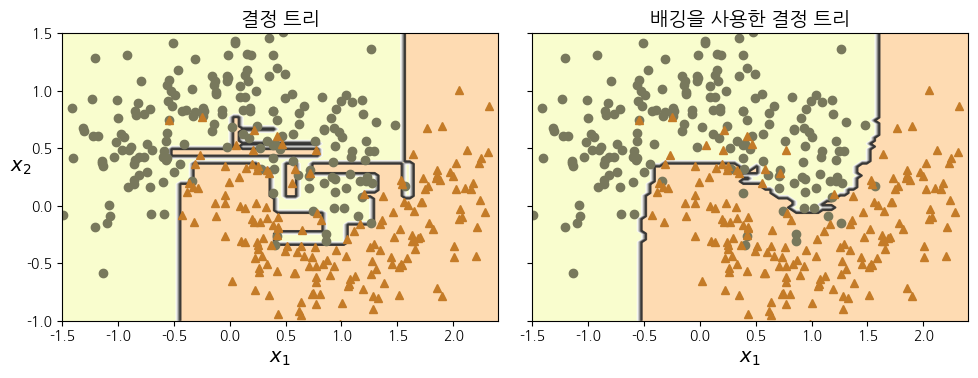

In [32]:
# 추가 코드 - 이 셀은 그림 7-5를 생성하고 저장합니다.

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("결정 트리")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("배깅을 사용한 결정 트리")
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

**그림 7-5 단일 결정 트리(왼쪽)와 500개의 트리로 만든 배깅 앙상블(오른쪽) 비교**

[**그림 7-5**]는 **단일 결정 트리의 결정 경계와 500개의 트리를 사용한 배깅 앙상블 (이전 코드로 만든 모델)의 결정 경계를 비교**한 것입니다.  
둘 다 moons 데이터셋에 훈련시켰습니다. 

여기서 볼 수 있듯이 **앙상블의 예측**이 결정 트리 하나의 예측보다 **일반화가 훨씬 잘된 것 같습니다**.  
**앙상블은 비슷한 편향에서 더 작은 분산을 만듭니다.** (훈련 세트의 오차 수가 거의 동일하지만 결정 경계는 덜 불규칙합니다).

배깅은 각 예측기가 학습하는 서브셋에 다양성을 추가하므로 배깅이 페이스팅보다 편향이 조금 더 높습니다.  

하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산이 줄어든다는 것을 의미합니다.  
**전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호됩니다.**  

그러나 시간과 CPU 파워에 여유가 있다면 교차 검증으로 배징과 페이스팅을 모두 평가해서 더 나은 쪽을 선택하는 것이 좋습니다

## 7.2.2 OOB 평가

배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있습니다. 

Baggingclassifier는 기본값으로 중복을 허용하여 (bootstrap=True) 훈련 세트의 크기만큼인 m개 샘플을 선택합니다.  
이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미합니다. 
**선택되지 않은 나머지 37%를 OOB out-of-bag 샘플**이라고 부릅니다. 

예측기마다 남겨진 37%는 모두 다릅니다. 예측기가 훈련되는 동안에는 OOB 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고  
**OOB 샘플을 사용해 평가**할 수 있습니다. **앙상블의 평가는 각 예측기의 OOB 평가를 평균하여 얻습니다.**

**사이킷런**에서 Baggingclassifier를 만들 때 **oob_score=True로 지정**하면 훈련이 끝난 후 **자동으로 OOB 평가를 수행**합니다. 

다음 코드는 이 과정을 보여줍니다. 평가 점수 결과는 oob_score_ 변수에 저장되어 있습니다.

In [43]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

**OOB 평가 결과를 보면 이 Baggingclassifier는 테스트 세트에서 약 89.6%의 정확도를 얻을 것**으로 보입니다. 확인해보죠

In [45]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

**테스트 세트에서 91.2%의 정확도를 얻었습니다.** OOB 평가는 2% 정도 낮아 조금 비관적이었습니다.  
OOB 샘플에 대한 결정 함수의 값도 oob_decision_function_ 변수에서 확인할 수 있습니다. 기반이 되는 예측기가 predict_proba() 메서드를 가지고 있기 때문에 결정 함수는 각 훈련 샘플의 클래스 확률을 반환합니다. 

다음 예를 보면 **OOB 평가는 첫 번째 훈련 샘플이 양성 클래스에 속할 확률을 67.6%, 음성 클래스에 속할 획률을 32.4%로 추정**하고 있습니다

In [46]:
bag_clf.oob_decision_function_[:3]  # probas for the first 3 instances

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

크기가 _m_인 데이터셋에서 하나의 샘플을 무작위로 뽑는 경우, 데이터셋의 각 샘플이 선택될 확률은 1/_m_ 이므로 선택되지 않을 확률은 1 - 1/_m_ 입니다.  

중복을 허용하여 _m_ 개의 샘플을 뽑는 경우, 모든 추첨은 독립적이므로 각 샘플의 선택되지 않을 확률은 (1 - 1/_m_)<sup>_m_</sup> 입니다.  

이제 _m_ 이 무한대에 가까워지면 exp(_x_)가 (1 + _x_/_m_)<sup>_m_</sup>의 극한과 같다는 사실을 이용해 보겠습니다.  

따라서 _m_ 이 크면 OOB 샘플의 비율은 약 exp(-1) ≈ 0.37이 됩니다. 따라서 대략 63%(1 - 0.37)가 샘플링됩니다.

In [47]:
# 추가 코드 - 63% 확률을 계산하는 방법을 보여줍니다.
print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))

0.6323045752290363
0.6321205588285577


# 7.3 랜덤 패치와 랜덤 서브스페이스

**Baggingclassifier는 특성 샘플링도 지원**합니다. **샘플링은 max_features, bootstrap, features 두 매개변수로 조절**됩니다. 

max_samples, boot strap과 동일한 방식으로 작동하지만 **샘플이 아닌 특성에 대한 샘플링**에 사용됩니다.  
따라서 **각 예측기는 랜덤으로 선택한 입력 특성의 일부분으로 훈련**됩니다.

이 기법은 훈련 속도를 크게 높일 수 있기 때문에 특히 (이미지와 같은) **매우 고차원의 데이터셋을 다룰 때 유용**합니다.  

훈련 특성과 샘플을 모두 샘플링하는 것을 **랜덤 패치 방식 random patches method** 이라고 힙니다.  

훈련 샘플을 모두 사용하고 (bootstrap=False이고 max_samples=1.0 으로 설정) 특성을 샘플링하는  
(bootstrap_features=True 그리고/또는 max_features는 1.0보다 작게 설정) 것을 **랜덤 서브스페이스 방식 random subspaces method** 이라고 합니다.

**특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춥니다.**

# 7.4 랜덤 포레스트

앞서 언급했듯이 **랜덤 포레스트**는 **일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블**입니다.  
일반적으로 max_samples를 훈련 세트의 크기로 지정합니다.

Bagging Classifier에 DecisionTreeClassifier를 넣어 만드는 대신 결정 트리에 최적화되어 사용하기 편리한 **RandomForestClassifier를 사용**할 수 있습니다.  
(비슷하게 회귀 문제를 위한 클래스로는 **RandomForestRegressor**가 있습니다). 

다음은 (최대 16개의 리프 노드를 갖는) **500개의 트리로 이뤄진 랜덤 포레스트 분류기를 가능한 모든 CPU 코어에서 훈련**시키는 코드 입니다.

In [48]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

랜덤 포레스트는 결정 트리의 배깅과 같습니다:

RandomForestClassifier는 몇 가지 예외가 있지만 (트리의 성장을 조절하기 위한) Decision TreeClassifier의 매개변수와 앙상블자체를 제어하는 데 필요한 Baggingclassifier의 매개변수를 모두 가지고 있습니다.

**랜덤 포레스트 알고리즘**은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 **랜덤으로 선택한 특성 후보 중에서 최적의 특성을 찾는 식**으로 **무작위성을 더 주입**합니다 (6장 참고). 

**기본적으로 $root(n)$ 개의 특성을 선택합니다** (n은 전체 특성 개수입니다).  
이는 결국 **트리를 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어냅니다**. 

다음은 Baggingclassifier를 앞의 RandomForestClassifier와 거의 동일 하게 만든 것입니다.

In [49]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

In [50]:
# 추가 코드 - 예측이 동일한지 확인합니다.
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
np.all(y_pred_bag == y_pred_rf)  # 동일한 예측

True

## 7.4.1 엑스트라트리

랜덤 포레스트에서 트리를 만들 때 (앞서 이야기한 것처럼) **각 노드는 랜덤으로 특성의 서브셋을 만들어 분할에 사용**합니다. 

트리를 더욱 랜덤하게 만들기 위해 (보통의 결정 트리처럼) **최적의 임곗값을 찾는 대신 후보 특성을 사용**해 **랜덤으로 분할한 다음 그중에서 최상의 분할을 선택**합니다. 

이렇게 하려면 **DecisionTreeClassifier를 만들 때 splitter="random"으로 지정**하기만 하면 됩니다.

이와 같이 극단적으로 랜덤한 트리의 랜덤 포레스트를 **익스트림 랜덤 트리 extremely randomized tree** 앙상블（또는 줄여서 **엑스트라 트리 extra-tree**）이라고 부릅니다. 

**여기서도 역시 편향이 늘어나는 대신 분산이 낮아집니다.** 모든 노드에서 특성마다 가장 최적의 임곗값을 찾는 것은 트리 알고리즘에서 가장 시간이 많이 소요되는 작업이므로 일반적인 랜덤 포레스트보다 **엑스트라 트리의 훈련 속도가 훨씬 빠릅니다.**

엑스트라 트리를 만들려면 사이킷런의 ExtraTreesClassifier를 사용합니다. boostrap 매개변수가 기본적으로 False인 것을 제외하고 사용법은 RandomForestClassifier와 같습니다. 

마찬가지로 ExtraTreesRegressor도 boostrap 매개변수가 기본적으로 False인 것을 제외하고 RandomForestRegressor 와 같은 API 를 제공합니다.

> **TIP** RandomForestClassifier가 ExtraTreesClassifier보다 더 나을지 혹은 나쁠지 예단하긴 어렵습니다.  
둘 다 시도해보고 교차 검증으로 비교해보는 것이 유일한 방법입니다

## 7.4.2 특성 중요도

**랜덤 포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 점**입니다.  

사이킷런은 어떤 특성을 사용한 노드가（랜덤 포레스트에 있는 모든 트리에 걸쳐서）**평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정**합니다. 더 정확히게는 가중치 평균이며, 각 노드의 가중치는 연관된 훈련 샘플 수와 같습니다（6장 참고）.

**사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화합니다.**  
이 값은 **feature_importances_ 변수에 저장**되어 있습니다. 

예를 들어 다음 코드는 （4장에서 소개한）iris 데이터셋에 RandomForestClassifier를 훈련시키고 각 특성의 중요도를 출력합니다. 가장 중요한 특성은 꽃잎의 길이（44%）와 너비（42%）이고 꽃받침의 길이와 너비는 비교적 덜 중요한 것으로 나타납니다（각각 11%와 2%）

In [51]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


이와 유사하게（3장에서 본） MNIST 데이터셋에 랜덤 포레스트 분류기를 훈련시키고 각 픽셀의 중요도를 그래프로 나타내면 ［그림 7-6］과 같은 이미지를 얻게 됩니다.

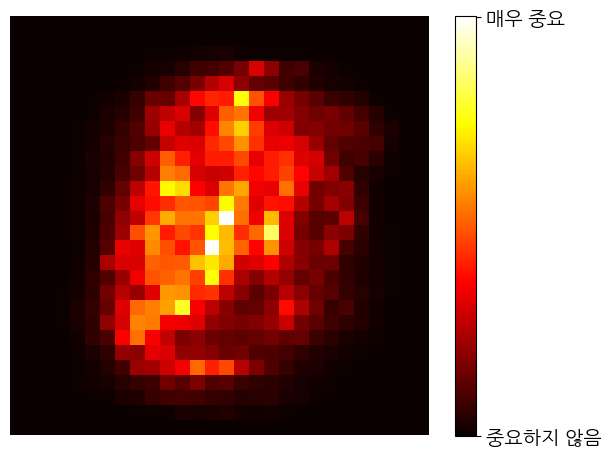

In [52]:
# 추가 코드 - 이 셀은 그림 7-6을 생성하고 저장합니다.

from sklearn.datasets import fetch_openml

# 사이킷런 1.4버전에서 parser 매개변수 기본값이 'liac-arff'에서 'auto'로 바뀌었습니다.
# 이전 버전에서도 동일한 결과를 내도록 명시적으로 'auto'로 지정합니다.
X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True,
                                as_frame=False, parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['중요하지 않음', '매우 중요'], fontsize=14)
plt.axis("off")
plt.title("그림 7-6 (랜덤포레스트 분류기에서 얻은) MNIST 픽셀 중요도")
save_fig("mnist_feature_importance_plot")
plt.show()

<img src="./images/fig07-05.png" width="50%"></img>

**랜덤 포레스트는 특히 특성을 선택해야 할 때 어떤 특성이 중요한지 빠르게 확인할 수 있어 매우 편리합니다.**

# 7.5 부스팅

**부스팅 boosting** (원래는 가설 부스팅 hypothesis boosting이라 불렀습니다)은 **약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법**을 말합니다.  

부스팅 방법의 아이디어는 **앞의 모델을 보완해 나가면서 일련의 예측기를 학습**시키는 것입니다.  
부스팅 방법에는 여러 가지가 있지만 가장 인기 있는 것은 **AdaBoost**（adaptive boosting의 줄임말, ‘에이다부스트’라고 읽습니다）와 그레이디언트 부스팅입니다.

AdaBoost부터 시작해보죠.

## 7.5.1 AdaBoost

이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 **이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것**입니다.  
이렇게 하면 **새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 됩니다**. 이것이 AdaBoost에서 사용하는 방식입니다.

예를 들어 AdaBoost 분류기를 만들 때 먼저 알고리즘이 기반이 되는 첫 번째 분류기（결정 트리）를 훈련 세트에서 훈련시키고 예측을 만듭니다.  
그런 다음 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높입니다. 

두 번째 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만듭니다. 그리고 다시 가중치를 업데이트하는 방식으로 계속됩니다（그림 7-7）.

<img src="./images/fig07-07.png" width="50%"></img>



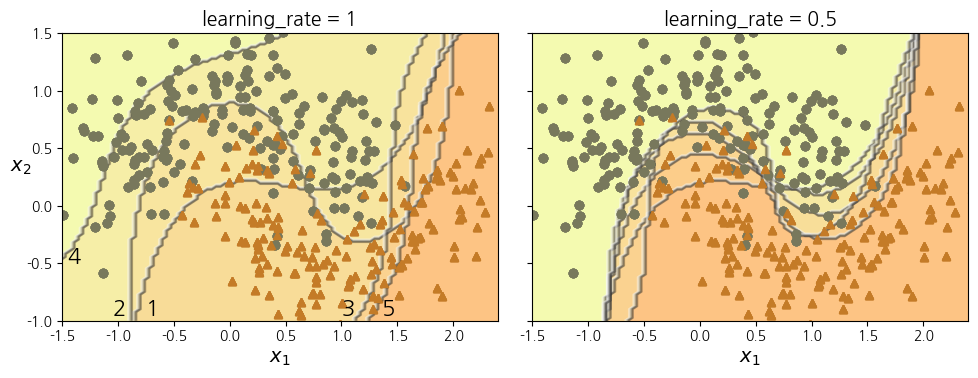

In [55]:
# 추가 코드 - 이 셀은 그림 7-8을 생성하고 저장합니다.

m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

**그림7-8 연속된 예측기의 결정 경계**

그림 7-8］은 moons 데이터셋에 훈련시킨 다섯 개의 연속된 예측기의 결정 경계입니다 (이 모델은 규제를 강하게 한 RBF 커널 SVM 분류기 입니다). 

**첫 번째 분류기가 많은 샘플을 잘못 분류해서 이 샘플들의 가중치가 높아졌습니다. 따라서 두 번째 분류기는 이 샘플들을 더 정확히 예측하게 됩니다.** 

오른쪽 그래프는 학습률을 반으로 낮춘 것만 빼고 똑같은 일련의 예측기를 나타낸 것입니다 (즉, 잘못 분류된 샘플의 가중치는 반복마다 절반 정도만 높아집니다).   

그림에서 볼 수 있듯이 이런 연속된 학습 기법은 **경사 하강법과 비슷한 면**이 있습니다. 경사 하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가는 반면 AdaBoost는 점차 더 좋아지도록 앙상블에 예측기를 추가합니다.

모든 예측기가 훈련을 마치면 이 앙상블은 배깅이나 페이스팅과 비슷한 방식으로 예측을 만듭니다. 하지만 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용됩니다.

> **CAUTION** 연속된 학습 기법에는 중요한 단점이 하나 있습니다. 각 예측기는 이전 예측기가 훈련되고 평가된 후에 학습될 수 있기 때문에 **훈련을 병렬화할 수 없습니다. 결국 배깅이나 페이스팅만큼 확장성이 높지 않습니다.**

AdaBoost 알고리즘을 더 자세히 들여다봅시다. 각 샘플 가중치 w(i)는 초기에 1/m로 초기화됩니다. 첫 번째 예측기가 학습되고 가중치가 적용된 오류율 n이 훈련 세트에 대해 계신됩니다.［식 7-1］을 참고하세요.

<img src="./images/eq07-01.png" width="50%"></img>

예측기의 가중치 $\alpha_i$는 ［식 7-2］를 사용해 계산됩니다. 여기서 $\eta$는 학습률 하이퍼파라미터이며 기본값은 1입니다.

예측기가 정확할수록 가중치는 더 높아집니다. 만약 랜덤 추측이라면 가중치는 0에 가까워집니다. 그러나 그보다 나쁘면(즉, 랜덤 추측보다 정확도가 낮으면) 가중치는 음수가 됩니다.

<img src="./images/eq07-02.png" width="25%"></img>

다음으로 AclaBoost 알고리즘이 [식 7-3]을 사용해 샘플의 가중치를 업데이트합니다. 즉, 잘못 분류된 샘플의 가중치가 높아집니다.

<img src="./images/eq07-03_1.png" width="50%"></img>


마지막으로 새 예측기가 업데이트된 가중치를 사용해 훈련되고 전체 과정이 반복됩니다(새 예측기의 가중치가 계신되고 샘플의 가중치를 업데이트해서 또 다른 예측기를 훈련시키는 식입니다). 이 알고리즘은 지정된 예측기 수에 도달히거나 완벽한 예측기가 만들어지면 중지됩니다.

예측을 할 때 AdaBoost는 단순히 모든 예측기의 예측을 계산하고 예측기 가중치 $\alpha_i$를 더해 예측 결과를 만듭니다. 가중치 합이 가장 큰 클래스가 예측 결과가 됩니다(식 7-4)

<img src="./images/eq07-04.png" width="50%"></img>

사이킷런은 SAMME(https://homl.info/27)라는 AdaBoost의 다중 클래스 버전을 사용합니다. 클래스가 두 개뿐이라면 SAMME는 AdaBoost와 동일힙니다. 예측기가 클래스의 확률을 추정할 수 있다면(즉, predict_proba() 메서드가 있다면) 사이킷런은 SAMME의 변형인 SAMME.R(끝의 R은 'Real’을 뜻합니다)을 사용합니다. 

이 알고리즘은 예측값 대신 클래스 확률을 기반으로 하며 일반적으로 성능이 더 좋습니다. 다음 코드는 사이킷런의 AdaBoostClassifier를 사용하여 (예상했겠지만 AdaBoostRegressor도 있습니다) 200개의 아주 얕은 결정 트리를 기반으로 하는 AclaBoost 분류기를 훈련시킵니다. 여기에서 사용하는 결정 트리는 max_depth=1 입니다. 다시 말해 결정 노드 하나와 리프 노드 두 개로 이루어진 트리입니다. 이 트리가 AdaBoostClassifier의 기본 추정기 입니다.

In [57]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

d:\00_Python_Projects\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

>**TIP** AdaBoost 앙상블이 훈련 세트에 과대적합되면 추정기 수를 줄이거나 추정기의 규제를 더 강하게 해보세요.

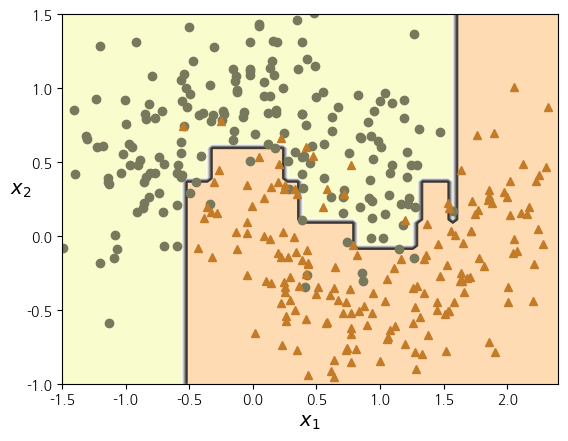

In [58]:
# 추가 코드 - AdaBoost 분류기에 대한 결정 경계가 어떻게 보이는지 궁금한 경우
plot_decision_boundary(ada_clf, X_train, y_train)

## 7.5.2 그레이디언트 부스팅

인기가 높은 또 하나의 부스팅 알고리즘은 **그레이디언트 부스팅gradient boosting** 입니다. AdaBoost처럼 그레이디언트 부스팅은 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가합니다. 

하지만 AdaBoost처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기 가 만든 **잔여 오차 residual error**에 새로운 예측기를 학습시킵니다.

결정 트리를 기반 예측기로 사용하는 간단한 회귀 문제를 풀어보겠습니다. 

이를 **그레이디언트 트리 부스팅 gradient tree boosting** 또는 그레디언트 **부스티드 회귀 트리 gradient boosted regression 
tree(GBRT)** 라고 합니다. 먼저 2차 방정식으로 잡음이 섞인 데이터셋을 생성하고 Decision TreeRegressor 를 학습시켜보겠습니다.

간단한 2차방정식 데이터셋을 만들고 여기에 `DecisionTreeRegressor`를 훈련시켜 보겠습니다:

In [59]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

이제 이전 예측기가 만든 잔여 오차에 대해 다른 결정 트리 회귀를 훈련해 보겠습니다:

이제 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeRegressor를 훈련시킵니다

In [60]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

그런 다음 두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델을 훈련시킵니다

In [61]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

이제 세 개의 트리를 포함히는 앙상블 모델이 생겼습니다. 새로운 샘플에 대한 예측을 만들려면 모든 트리의 예측을 더하면 됩니다.

In [62]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

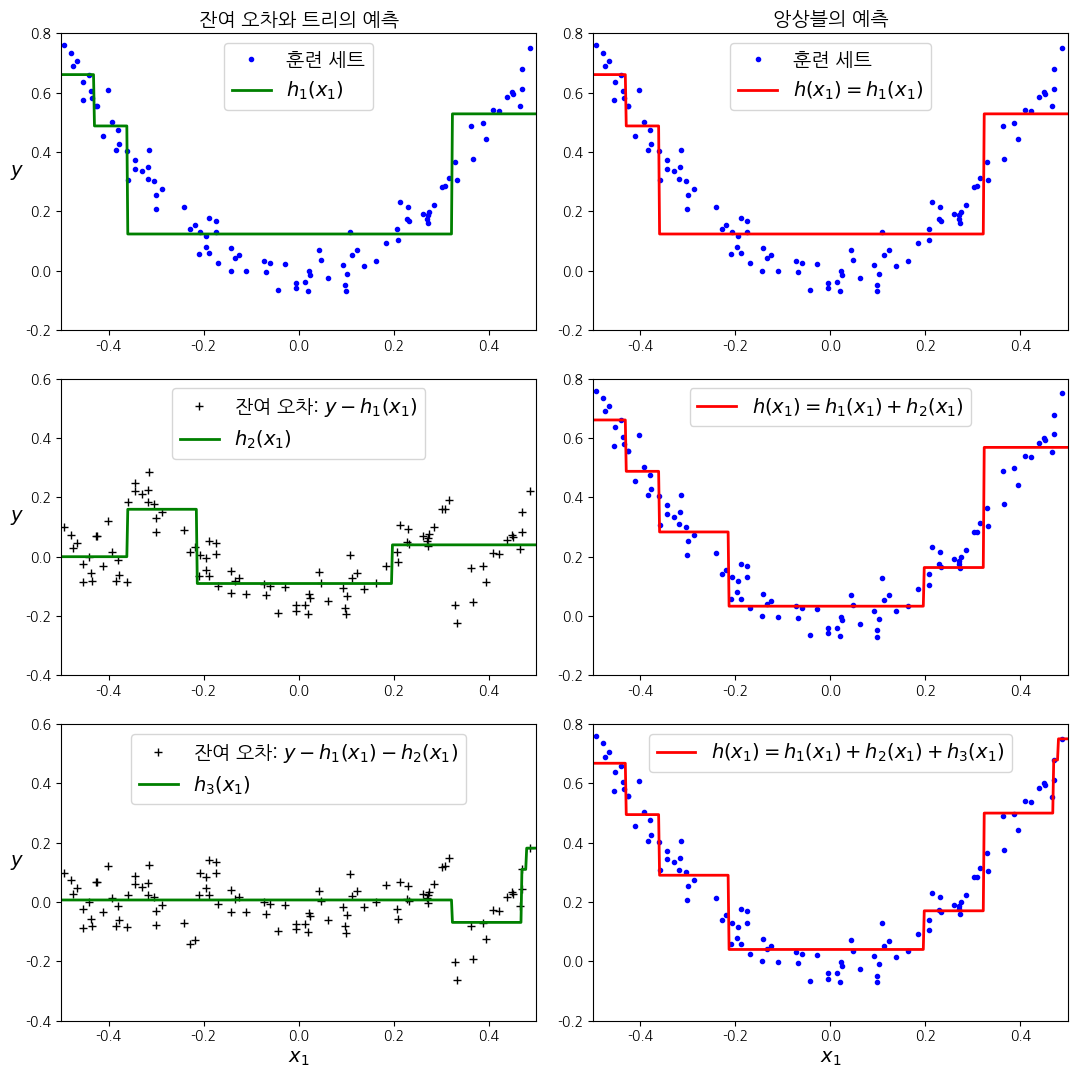

In [63]:
# 추가 코드 - 이 셀은 그림 7-9를 생성하고 저장합니다.

def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="훈련 세트")
plt.ylabel("$y$  ", rotation=0)
plt.title("잔여 오차와 트리의 예측")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="훈련 세트")
plt.title("앙상블의 예측")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="잔여 오차: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="잔여 오차: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

save_fig("gradient_boosting_plot")
plt.show()

**그림 7-9 이 그레디언트 부스팅 그래프에서 첫번째 예측기(왼쪽)가 평소처럼 훈련됩니다. 그다음 연이은 예측기(왼쪽 중간, 왼쪽 아래)가 이전의 예측기의 잔여 오차에서 훈련됩니다. 오른쪽 열은 만들어진 앙상블의 예측을 보여줍니다.**

[그림 7-9]의 왼쪽 열은 이 세 트리의 예측이고 오른쪽 열은 앙상블의 예측입니다. 첫 번째 행에서는 앙상블에 트리가 하나만 있어서 첫 번째 트리의 예측과 완전히 같습니다. 

두 번째 행에서는 새로운 트리가 첫 번째 트리의 잔여 오차에 대해 학습되었습니다. 오른쪽의 앙상블 예측이 두 개의 트리 예측의 합과 같은 것을 볼 수 있습니다. 

비슷하게 세 번째 행에서는 또 다른 트리가 두 번째 트리의 잔여 오차에 훈련되었습니다. 트리가 앙상블에 추가될수록 앙상블의 예측 
이 점차 좋아지는 것을 알 수 있습니다.

사이킷런의 GradientBoostingRegressor를 사용하면 GBRT 앙싱블을 간단하게 훈련시킬 수 있습니다(분류를 위한 GradientBoostingClassifier 클래스도 있습니다). 트리 수(n_estimators)와 같이 앙상블의 훈련을 제어하는 매개변수는 물론 RandomForestRegressor와 아주 비슷하게 결정 트리의 성장을 제어하는 매개변수(max_depth, min_samples_leaf)를 가지고 있습니다. 

다음은 이전에 만든 것과 같은 앙상블을 만드는 코드입니다

이제 그레이디언트 부스팅 회귀를 시도해 보겠습니다:

In [64]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

learning_rate 매개변수가 각 트리의 기여도를 조절합니다. 이를 0.05처럼 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아집니다. 이는 축소라고 부르는 규제 방법입니다. 

[그림 7-10]은 다른 하이퍼 파라미터로 훈련시킨 두 개의 GBRT 앙상블을 보여줍니다. 왼쪽은 훈련 세트를 학습하기에는 트리가 충분하지 않은 반면 오른쪽은 적정한 개수의 트리를 사용합니다. 트리를 더 많이 추가하면 GBRT가 훈련 세트에 과대적합되기 시작할 것입니다

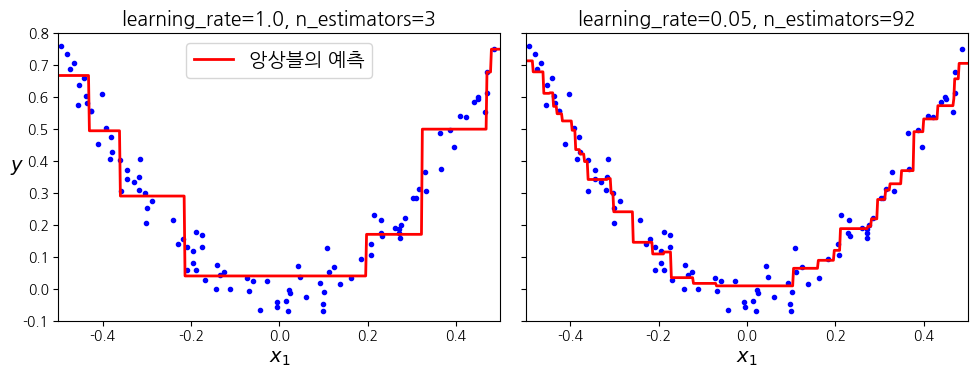

In [67]:
# 추가 코드 - 이 셀은 그림 7-10을 생성하고 저장합니다.

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="앙상블의 예측")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

save_fig("gbrt_learning_rate_plot")
plt.show()

**그림 7-10 예측기가 부족한 경우 (왼쪽)와 충분한 경우 (오른쪽)의 GBRT 앙상블**

최적의 트리 개수를 찾으려면 평소처럼 GridSearchCV 또는 RandomizedSearchCV를 사용하여 교차 검증을 수행할 수 있지만 **더 간단한 방법이 있습니다**. 

n_iter_no_change 하이퍼 파라미터를 정숫값（예 10）으로 설정하면 훈련 중에 마지막 10개의 트리가 도움이 되지 않는 경우 
GradientBoostingRegressor가 트리 추가를 자동으로 중지합니다. 

이것은 （4장에서 소개한） 단순한 조기 종료 기법이지만 약간의 인내심을 가지고 몇 번의 반복에서 진전이 없는 것을 확인한 후 중지합니다. 조기 종료를 사용해 앙상블을 훈련해봅시다

In [69]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [70]:
gbrt_best.n_estimators_

92

n_iter_no_change를 설정하면 fit() 메서드가 자동으로 훈련 세트를 더 작은 훈련 세트와 검증 세트로 분할하므로 새 트리를 추가할 때마다 모델의 성능을 평가할 수 있습니다. 검증 세트의 크기는 validation_fraction 하이퍼파라미터에 의해 제어되며, 기본값은 10%입니다. tol 하이퍼파라미터는 무시할 수 있는 최대 성능 향상을 결정합니다. 기본값은 0.00이입니다.

GradientBoostingRegressor는 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있는 subsample 매개변수도 지원합니다. 예를 들어 subsample=0.25라고 하면 각 트리는 랜덤으로 선택된 25%의 훈련 샘플로 학습됩니다. 짐작했겠지만 편향이 높아지는 대신 분산이 낮 
아지게 됩니다. 또한 훈련 속도도 상당히 빨라집니다. 

이런 기법을 **확률적 그레이디언트 부스팅 stochastic gradient boosting** 이라고 합니다.

## 7.5.3 히스토그램 기반 그레이디언트 부스팅

사이킷런은 대규모 데이터셋에 최적화된 또 다른 GBRT 구현인 **히스토그램 기반 그레이디언트 부스팅 histogram-based gradient boosting (HGB)** 도 제공합니다.

이 알고리즘은 입력 특성을 구간으로 나누어 정수로 대체하는 방식으로 작동합니다. 구간의 개수는 max_bins 하이퍼파라미터에 의해 제어되며, 기본값은 255이고 이보다 높게 설정할 수 없습니다. 구간 분할을 사용하면 학습 알고리즘이 평가해야 하는 가능한 임곗값의 수를 크게 줄일 수 있습니다. 또한 정수로 작업하면 더 빠르고 메모리 효율적인 데이터 구조를 사용할 수 있습니다. 그리고 구간을 분할히는 방식 덕분에 각 트리를 학습할 때 특성을 정 렬할 필요가 없습니다.

그 결과, 이 구현의 계산 복잡도는 O(n x m x log(m))이 아닌 O(b x m) 이며, 여기서 b는 구간의 개수, m은 훈련 샘플의 개수, n은 특성의 개수입니다. 이는 실제로 HGB가 대규모 데이터셋에서 일반 GBRT보다 수백 배 빠르게 훈련할 수 있다는 것을 의미합니다. 

그러나 구간 분할은 규제처럼 작동해 정밀도 손실을 유발하므로 데이터셋에 따라 과대적합을 줄이는 데 도움이 될 수도 있고 과소적합을 유발할 수도 있습니다

GradientBoostingClassifier와유사히지만 몇 가지 주목할 만한 차이점이 있습니다.
- 인스턴스 수가 10,000개보다 많으면 조기 종료가 자동으로 활성화됩니다. early_stopping 매개변수를 True 또는 False로 설정하여 조기 종료를 항상 켜거나 끌 수 있습니다.
- subsample 매개변수가 지원되지 않습니다.
- n_estimators 매개변수가 max_iter로 바뀌었습니다.
- 조정할 수 있는 결정 트리 하이퍼파라미터는 max_leaf_nodes, min_samples_leaf, max_depth뿐입니다.

HGB 클래스는 범주형 특성과 누락된 값을 지원합니다. 이로 인해 전처리가 상당히 간소화됩니다.  
그러나 범주형 특성은 0 〜 max_bins 사이의 정수로 표현돼야 합니다. 이를 위해 OrdinalEncoder를 사용할 수 있습니다.  

예를 들어 2장에서 소개한 캘리포니아 주택 데이터셋에 대한 전체 파이프라인을 구축하고 훈련하는 방법은 다음과 같습니다

In [74]:
# 추가 코드 - 2장에서 설명했습니다.

import pandas as pd
from sklearn.model_selection import train_test_split
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

전체 파이프라인이 임포트 구문만큼 짧습니다! 누락된 값을 채우고, 스케일을 조정하고, 원-핫 인코딩을 처리하지 않아도 되므로 정말 편리합니다. 
범주형 열의 인덱스(또는 불리언 배열)로 categorical_features를 설정해야 한다는 점에 유의하세요. 

하이퍼파라미터 튜닝 없이도 이 모델은 약 47,600의 RMSE를 산출하는데 이는 그리 나쁘지 않은 수치입니다.

In [75]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]),
                            remainder="passthrough"),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42)
)
hgb_reg.fit(housing, housing_labels)

d:\00_Python_Projects\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

In [76]:
# 추가 코드 - hgb_reg 모델에 대한 RMSE 통계를 평가합니다.

from sklearn.model_selection import cross_val_score

hgb_rmses = -cross_val_score(hgb_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
pd.Series(hgb_rmses).describe()

count       10.000000
mean     47613.307194
std       1295.422509
min      44963.213061
25%      47001.233485
50%      48000.963564
75%      48488.093243
max      49176.368465
dtype: float64

# 7.6 스태킹

이 장에서 이야기할 마지막 앙상블 모델은 **스태킹 stacing(stacked generalization의 줄임말)** 입니다. 

이는 ‘앙상블에 속한 모든 예측기의 예측을 취합하는 (직접 투표 같은) 간단한 함수를 사용하는 대신 취합하는 모델을 훈련시킬 수 없을까?’라는 기본 아이디어에서 출발합니다.

[그림 7-11]은 새로운 샘플에 회귀 작업을 수행하는 앙상블을 보여줍니다. 

아래의 세 예측기는 각각 다른 값 (3.1, 2.7, 2.9)을 예측하고 마지막 예측기 (**블렌더 blender 또는 메타 학습기 meta learner** 라고 합니다)가 이 예측을 입력으로 받아 최종 예측 (3,0) 을 만듭니다.

<img src="./images/fig07-11.png" width="50%"></img>

블렌더를 훈련하려면 먼저 **블렌딩 blending** 훈련 세트를 만들어야 합니다. 

앙상블의 모든 예측기에서 cross_val_predict()를 사용하여 원본 훈련 세트에 있는 각 샘플에 대한 표본 외 예측을 얻습니다（그림 7-12）.   
이를 블렌더를 훈련하기 위한 입력 특성으로 사용하고 타깃은 원본 훈련 세트에서 간단히 복사할 수 있습니다.   
원본 훈련 세트의 특성 개수（이 예에서는 하나）에 관계없이 블렌딩 훈련 세트에는 예측기당 하나의 입력 특성이 포함됩니다（이 예에서는 세 개）.   

(**블렌더가 학습되면 기본 예측기는 전체 원본 훈련 세트로 마지막에 한 번 더 재훈련됩니다.**)

<img src="./images/fig07-12.png" width="50%"></img>

실제로 [그림 7-13]과 같이 여러 가지 블렌더 (예 선형 회귀를 사용하는 블렌더, 랜덤 포레스트 회귀를 사용하는 블렌더)를 이러한 방식으로 훈련하여 전체 블렌더 계층을 얻은 다음 그 위에 다른 블렌더를 추가하여 최종 예측을 생성하는 것이 가능합니다. 

**이렇게 하면 성능을 조금 더 끌어올릴 수 있지만 훈련 시간과 시스템 복잡성 측면에서 비용이 증가합니다.**

<img src="./images/fig07-13.png" width="50%"></img>

사이킷런은 스태킹 앙상블을 위한 StackingClassifier와 StackingRegressor 클래스를 제공합니다.  
예를들어 이 장의 시작부분에서 moons 데이터셋에 사용한 VotingClassifier를 StackingClassifier로 대체할 수 있습니다

In [77]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # 교차 검증 폴드 수
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [78]:
stacking_clf.score(X_test, y_test)

0.928

각 예측기에 대해 스태킹 분류기는 사용 가능한 경우 predict_proba()를 호출하고, 그렇지 않은 경우 decision_function()을 사용하거나 최후의 수단으로 predict()를 호출합니다. 최종 예측기를 제공하지 않으면 StackingClassifier는 LogisticRegression을 사용하고 StackingRegressor 는 RidgeCV 를 사용합니다.

테스트 세트에서 이 스태킹 모델을 평가하면 92.8%의 정확도를 얻을 수 있으며, 이는 92%를 얻은 간접 투표 방식의 분류기보다 약간 더 나은 결과입니다.

**결론적으로 앙상블 방법은 다재다능하고 강력하며 사용법이 매우 간단합니다.**

- 랜덤 포레스트, AdaBoost, GBRT는 대부분의 머신러닝 작업에서 가장 먼저 테스트해야 하는 모델이며. 특히 서로 다른 종류로 구성된 표 형식 데이터에서 빛을 발합니다. 

- 또한 전처리가 거의 필요하지 않기 때문에 프로토타입을 빠르게 구축하는 데 적합합니다. 

- **마지막으로 투표 기반 분류기와 스태킹 분류기 같은 앙상블 방법은 시스템 성능을 한계까지 끌어올리는 데 도움이 될 수 있습니다.**

# 연습문제 해답

## 1. to 7.

부록 A 참조

## 8. 투표 기반 분류기

문제: _MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눕니다(예를 들면 훈련에 50,000개 샘플, 검증에 10,000개 샘플, 테스트에 10,000개 샘플)._

MNIST 데이터셋은 앞서 로드했습니다. 이 데이터셋은 이미 훈련 세트(처음 60,000개의 샘플)와 테스트 세트(마지막 10,000개의 샘플)로 분할되어 있으며, 훈련 세트는 이미 뒤섞여 있습니다. 따라서 처음 50,000개의 샘플을 새 훈련 세트에, 다음 10,000개의 샘플을 검증 세트에, 마지막 10,000개의 샘플을 테스트 세트에 사용하기만 하면 됩니다:

In [79]:
X_train, y_train = X_mnist[:50_000], y_mnist[:50_000]
X_valid, y_valid = X_mnist[50_000:60_000], y_mnist[50_000:60_000]
X_test, y_test = X_mnist[60_000:], y_mnist[60_000:]

문제: _그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM 분류기 같은 여러 종류의 분류기를 훈련시킵니다._

In [80]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

사이킷런 1.5에서 `LinearSVC`의 `dual` 매개변수 기본값이 `True`에서 `"auto"`로 바뀔 예정입니다. 동일한 결과가 유지되도록 명시적으로 `True`로 지정합니다.

In [81]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, dual=True, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [82]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("훈련 모델:", estimator)
    estimator.fit(X_train, y_train)

훈련 모델: RandomForestClassifier(random_state=42)
훈련 모델: ExtraTreesClassifier(random_state=42)
훈련 모델: LinearSVC(dual=True, max_iter=100, random_state=42, tol=20)
훈련 모델: MLPClassifier(random_state=42)


In [83]:
[estimator.score(X_valid, y_valid) for estimator in estimators]

[0.9736, 0.9743, 0.8662, 0.9646]

선형 SVM은 다른 분류기보다 성능이 훨씬 뛰어납니다. 하지만 투표 기반 분류기의 성능을 향상시킬 수 있으므로 그대로 둡니다.

문제: _그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 방법을 사용해 앙상블로 연결해보세요._

In [84]:
from sklearn.ensemble import VotingClassifier

In [85]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [86]:
voting_clf = VotingClassifier(named_estimators)

In [87]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(dual=True, max_iter=100,
                                        random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [88]:
voting_clf.score(X_valid, y_valid)

0.9755

`VotingClassifier`는 각 분류기의 복제본을 만들어 원래 클래스 이름이 아닌 클래스 인덱스를 레이블로 사용하여 복제본을 훈련시켰습니다. 따라서 이러한 복제본을 평가하려면 클래스 인덱스도 제공해야 합니다. 클래스를 클래스 인덱스로 변환하기 위해 `LabelEncoder`를 사용할 수 있습니다:

In [89]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_valid_encoded = encoder.fit_transform(y_valid)

그러나 MNIST의 경우 숫자가 클래스 ID와 일치하므로 클래스 이름을 정수로 변환하는 것이 더 간단합니다:

In [90]:
y_valid_encoded = y_valid.astype(np.int64)

이제 분류기 복제본을 평가해 보겠습니다:

In [91]:
[estimator.score(X_valid, y_valid_encoded)
 for estimator in voting_clf.estimators_]

[0.9736, 0.9743, 0.8662, 0.9646]

SVM을 제거하여 성능이 향상되는지 확인해 보겠습니다. 다음과 같이 `set_params()`를 사용하여 `"drop"`으로 설정하여 추정기를 제거할 수 있습니다:

In [92]:
voting_clf.set_params(svm_clf="drop")

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', 'drop'),
                             ('mlp_clf', MLPClassifier(random_state=42))])

이렇게 하면 추정기 목록이 업데이트됩니다:

In [93]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', 'drop'),
 ('mlp_clf', MLPClassifier(random_state=42))]

그러나 _훈련된_ 추정기 목록은 업데이트하지 않습니다:

In [94]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(dual=True, max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

In [95]:
voting_clf.named_estimators_

{'random_forest_clf': RandomForestClassifier(random_state=42),
 'extra_trees_clf': ExtraTreesClassifier(random_state=42),
 'svm_clf': LinearSVC(dual=True, max_iter=100, random_state=42, tol=20),
 'mlp_clf': MLPClassifier(random_state=42)}

따라서 `VotingClassifier`를 다시 훈련하거나 `estimators_`와 `named_estimators_`에 있는 훈련된 추정기 목록에서 SVM을 제거할 수 있습니다:

In [96]:
svm_clf_trained = voting_clf.named_estimators_.pop("svm_clf")
voting_clf.estimators_.remove(svm_clf_trained)

이제 `VotingClassifier`를 다시 평가해 보겠습니다:

In [97]:
voting_clf.score(X_valid, y_valid)

0.9763

조금 나아졌습니다! SVM이 성능을 저해하고 있었습니다. 이제 간접 투표 분류기를 사용해 보겠습니다. 실제로 분류기를 재학습할 필요 없이 `voting`를 `soft`로 설정하면 됩니다:

In [98]:
voting_clf.voting = "soft"

In [99]:
voting_clf.score(X_valid, y_valid)

0.97

이런, 이 경우에는 직접 투표 방식이 더 낫군요.

문제: _앙상블을 얻고 나면 테스트 세트로 확인해보세요. 개개의 분류기와 비교해서 성능이 얼마나 향상되나요?_

In [100]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9739

In [101]:
[estimator.score(X_test, y_test.astype(np.int64))
 for estimator in voting_clf.estimators_]

[0.968, 0.9703, 0.9644]

투표 분류기는 최고 모델의 오류율을 약 3%에서 2.7%로 낮췄으며, 이는 10%의 오류를 줄인 것입니다.

## 9. 스태킹 앙상블

문제: _이전 연습문제의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어보세요. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터이고 타깃은 이미지의 클래스입니다. 새로운 훈련 세트에 분류기 하나를 훈련시켜보세요._

In [102]:
X_valid_predictions = np.empty((len(X_valid), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_valid_predictions[:, index] = estimator.predict(X_valid)

In [103]:
X_valid_predictions

array([['3', '3', '3', '3'],
       ['8', '8', '8', '8'],
       ['6', '6', '6', '6'],
       ...,
       ['5', '5', '5', '5'],
       ['6', '6', '6', '6'],
       ['8', '8', '8', '8']], dtype=object)

In [104]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True,
                                            random_state=42)
rnd_forest_blender.fit(X_valid_predictions, y_valid)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [105]:
rnd_forest_blender.oob_score_

0.9726

이 블렌더를 미세 조정하거나 다른 유형의 블렌더(예: `MLPClassifier`)를 사용해 본 다음, 항상 그렇듯이 교차 검증을 통해 가장 적합한 블렌더를 선택할 수 있습니다.

문제: _축하합니다. 방금 블렌더를 훈련시켰습니다. 그리고 이 분류기를 모아서 스태킹 앙상블을 구성했습니다! 이제 테스트 세트에 앙상블을 평가해보세요. 테스트 세트의 각 이미지에 대해 모든 분류기로 예측을 만들고 앙상블의 예측 결과를 만들기 위해 블렌더에 그 예측을 주입합니다. 앞서 만든 투표 분류기와 비교하면 어떤가요?_

In [106]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [107]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [108]:
accuracy_score(y_test, y_pred)

0.9692

이 스태킹 앙상블은 앞서 학습한 투표 기반 분류기보다 성능이 좋지 않습니다.

문제: _이제 `StackingClassifier`를 사용하여 다시 시도해 보세요. 성능이 더 좋아졌나요? 그렇다면 그 이유는 무엇인가요?_

`StackingClassifier`는 K-겹 교차 검증을 사용하기 때문에 별도의 검증 세트가 필요하지 않으므로 훈련 세트와 검증 세트를 더 큰 훈련 세트로 합쳐보겠습니다:

In [109]:
X_train_full, y_train_full = X_mnist[:60_000], y_mnist[:60_000]

이제 전체 훈련 세트에서 스태킹 분류기를 생성하고 훈련해 보겠습니다:

**경고**: 다음 셀은 기본적으로 5-겹 검증을 사용하기 때문에 실행하는 데 시간이 꽤 오래 걸립니다(하드웨어에 따라 15~30분 정도 소요). 이 셀은 4개의 분류기를 전체 훈련 세트의 80%에 대해 각각 5회씩 훈련하여 예측을 하고, 마지막으로 전체 훈련 세트에 대해 각각 한 번씩 훈련하여 예측에 대한 최종 모델을 훈련합니다. 총 25개의 모델을 훈련해야 합니다!

In [110]:
stack_clf = StackingClassifier(named_estimators,
                               final_estimator=rnd_forest_blender)
stack_clf.fit(X_train_full, y_train_full)

StackingClassifier(estimators=[('random_forest_clf',
                                RandomForestClassifier(random_state=42)),
                               ('extra_trees_clf',
                                ExtraTreesClassifier(random_state=42)),
                               ('svm_clf',
                                LinearSVC(dual=True, max_iter=100,
                                          random_state=42, tol=20)),
                               ('mlp_clf', MLPClassifier(random_state=42))],
                   final_estimator=RandomForestClassifier(n_estimators=200,
                                                          oob_score=True,
                                                          random_state=42))

In [111]:
stack_clf.score(X_test, y_test)

0.9795

`StackingClassifier`는 앞서 시도한 사용자 정의 스태킹 구현보다 훨씬 뛰어난 성능을 발휘합니다! 이는 크게 두 가지 이유 때문입니다:

* 검증 세트를 별도로 사용하지 않았기 때문에 더 큰 데이터 집합에 대해 `StackingClassifier`를 학습시켰습니다.
* 사용 가능한 경우 `predict_proba()`를, 그렇지 않으면 `decision_function()`을, 그렇지 않으면 `predict()`를 사용했습니다. 이렇게 하면 블렌더가 훨씬 더 미묘한 입력을 처리할 수 있습니다.

오늘은 여기까지입니다. 이 장의 코드와 연습 문제를 모두 완료하신 것을 축하드립니다!